In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Latex
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import linregress

In [2]:
class CoupledPendulumAnalyzer:

    def __init__(self, path, mode, smoothing=True):

        """
        Parameters:
            path : str
                Path to data file
            mode : {'inphase', 'outphase', 'beat'}
                Determines how signals are combined
            smoothing : bool
                Apply Savitzky–Golay smoothing to reduce noise
        """

        self.path = path
        self.mode = mode
        self.smoothing = smoothing

        # Results
        self.t = self.U1 = self.U2 = self.signal = self.x = None
        self.peaks = None
        self.T_stats = {}
        self.f_stats = {}
        self.beat_stats = {}


    # Load
    def load_data(self):
        df = pd.read_csv(self.path, delim_whitespace=True, decimal=',')
        df.columns = ['t', 'U1', 'U2']

        self.t, self.U1, self.U2 = df['t'].to_numpy(), df['U1'].to_numpy(), df['U2'].to_numpy()

        return self

    # Combine signals
    def combine_signals(self):
        if self.mode == 'inphase':
            s = (self.U1 + self.U2) / 2.0
        elif self.mode == 'outphase':
            s = (self.U1 - self.U2) / 2.0
        elif self.mode == 'beat':
            # For beat mode, use one pendulum (U1)
            s = self.U1
        else:
            raise ValueError("mode must be 'inphase', 'outphase', or 'beat'")

        self.signal = s

        return self


    # Smoothing and DC removal
    def preprocess(self):
        if self.signal is None:
            raise RuntimeError('Call combine_signals() first')
        
        s = self.signal

        # Smoothing
        if self.smoothing:
            N = len(s)
            win = max(5, (N // 200) | 1)
            s = savgol_filter(s, window_length=win, polyorder=3, mode='interp')

        # DC removal
        self.x = s - np.mean(s)
        
        return self
    
    # Peak detection
    def detect_peaks(self, min_time=0.2, prom_frac=0.2):
        if self.x is None:
            raise RuntimeError('Call preprocess() first')
        
        dt = np.median(np.diff(self.t))
        prom = prom_frac * (np.max(self.x) - np.min(self.x))
        min_dist = int(max(1, min_time / dt)) if dt > 0 else 1

        peaks, props = find_peaks(self.x, prominence=prom, distance=min_dist)
        self.peaks = (peaks, props)
        
        return self

    # Compute period and uncertainty
    def compute_period(self):


        if self.peaks is None:
            raise RuntimeError('Call detect_peaks() first')
        
        peaks, _ = self.peaks
        Tp = np.diff(self.t[peaks])
        N = len(Tp)

        if len(Tp) == 0:
            raise ValueError("No valid peaks found — check prominence or distance thresholds")

        
        T_mean = np.mean(Tp)
        T_med = np.median(Tp)
        T_std = np.std(Tp, ddof=1) if N > 1 else np.nan
        u_T = T_std / np.sqrt(N) if N > 1 else np.nan # Standard error

        f_med = 1.0 / T_med
        f_std = T_std / (T_med**2) if np.isfinite(T_std) else np.nan
        u_f = u_T / (T_med**2) if np.isfinite(u_T) else np.nan

        self.T_stats = {'median': T_med, 'mean': T_mean, 'std': T_std, 'u_T': u_T}
        self.f_stats = {'median': f_med, 'std': f_std, 'u_f': u_f}

        return self

    # Beat mode analysis with uncertainties
    def compute_beat_periods(self):
        """
        For beat mode:
          - Computes T (beat oscillation period) from x(t) peaks
          - Computes T_s (beat period) from smoothed |x(t)|
          - If no clear envelope peaks: estimates T_s from envelope autocorrelation
          - Always returns usable results for reporting
        """
        if self.mode != 'beat':
            raise RuntimeError("compute_beat_periods() is only for mode='beat'")
        if self.x is None:
            raise RuntimeError('Call preprocess() first')

        t = self.t
        x = self.x
        dt = np.median(np.diff(t))
        amplitude = np.max(x) - np.min(x)

        # Beat oscillation period
        prom_fast = 0.2 * amplitude
        min_dist_fast = int(max(1, 0.05 / dt))
        peaks_fast, _ = find_peaks(x, prominence=prom_fast, distance=min_dist_fast)
        T_fast = np.diff(t[peaks_fast])
        Nf = len(T_fast)
        T_fast_med = np.median(T_fast) if Nf else np.nan
        T_fast_std = np.std(T_fast, ddof=1) if Nf > 1 else np.nan
        u_T_fast = T_fast_std / np.sqrt(Nf) if Nf > 1 else np.nan
        f_fast = 1 / T_fast_med if np.isfinite(T_fast_med) else np.nan
        u_f_fast = u_T_fast / (T_fast_med**2) if np.isfinite(u_T_fast) else np.nan

        # Beat period
        win_env = int(round(2.5 * T_fast_med / dt)) if np.isfinite(T_fast_med) else 101
        win_env = win_env + 1 if win_env % 2 == 0 else win_env
        env = savgol_filter(np.abs(x), window_length=win_env, polyorder=3, mode='interp')

        prom_env = 0.1 * (np.max(env) - np.min(env))
        min_dist_env = int(max(1, 0.5 * T_fast_med / dt)) if np.isfinite(T_fast_med) else 50
        peaks_env, _ = find_peaks(env, prominence=prom_env, distance=min_dist_env)

        if len(peaks_env) >= 3:
            # every 2nd peak → full beat period
            T_env = t[peaks_env[2:]] - t[peaks_env[:-2]]
            Ne = len(T_env)
            T_env_med = np.median(T_env)
            T_env_std = np.std(T_env, ddof=1) if Ne > 1 else np.nan
            u_T_env = T_env_std / np.sqrt(Ne) if Ne > 1 else np.nan
            f_env = 1 / T_env_med
            u_f_env = u_T_env / (T_env_med**2) if np.isfinite(u_T_env) else np.nan
            note = "Envelope peaks detected normally."
        else:
            # Fallback: use autocorrelation of |x| to find beat period
            e = env - np.mean(env)
            corr = np.correlate(e, e, mode='full')
            corr = corr[corr.size // 2:]
            lag = np.arange(len(corr)) * dt
            # ignore zero lag, take first significant side maximum
            lag_peaks, _ = find_peaks(corr, distance=int(1.0 / dt))
            if len(lag_peaks) > 1:
                T_env_med = lag[lag_peaks[1]]
                u_T_env = np.nan
                f_env = 1 / T_env_med
                u_f_env = np.nan
                note = "Envelope weak — T_s estimated from autocorrelation."
            else:
                T_env_med = np.nan
                u_T_env = np.nan
                f_env = np.nan
                u_f_env = np.nan
                note = "Envelope too weak — no reliable T_s."
        

        self.beat_stats = {
            'T_fast': T_fast_med, 'u_T_fast': u_T_fast, 'f_fast': f_fast, 'u_f_fast': u_f_fast,
            'T_env': T_env_med, 'u_T_env': u_T_env, 'f_env': f_env, 'u_f_env': u_f_env,
            'peaks_fast': peaks_fast, 'peaks_env': peaks_env, 'envelope_trace': env,
            'note': note
        }
        print(f"[Beat mode] {note}")
        return self


    # Reporting
    def report(self):
        
        if self.mode == 'beat' and self.beat_stats:
            b = self.beat_stats
            display(Latex(
                f"Beat mode from data:\\\n" +
                f"Beat oscillation period  $T  = {b['T_fast']:.6f} \\pm {b['u_T_fast']:.6f} s  (f = {b['f_fast']:.6f} \\pm {b['u_f_fast']:.6f} Hz)$\\\n" +
                f"Beat period   $T_s = {b['T_env']:.6f} \\pm {b['u_T_env']:.6f} s  (f_s = {b['f_env']:.6f} \\pm {b['u_f_env']:.6f} Hz)$"
            ))
        else:
            T, f = self.T_stats, self.f_stats
            display(Latex(
                f"{self.mode.capitalize()} mode \\\n" +        
                f" $T = {T['median']:.6f} \\pm {T['u_T']:.6f} s  (mean = {T['mean']:.6f} s, std = {T['std']:.6f} s)$ \\\n" +
                f" $f = {f['median']:.6f} \\pm {f['u_f']:.6f} Hz  (\\sigma_f ≈ {f['std']:.6f} Hz)$"
            ))


    # Visualization
    def plot(self):
        if self.peaks is None:
            raise RuntimeError('Call detect_peaks() first')
        
        plt.figure(figsize=(10, 4))
        plt.plot(self.t, self.U1, label='U1')
        plt.plot(self.t, self.U2, label='U2')
        plt.plot(self.t, self.x, label='Smoothed signal')

        if self.mode == 'beat' and self.beat_stats:
            peaks_env = self.beat_stats['peaks_env']
            plt.plot(self.t[peaks_env], self.x[peaks_env], 'ko', label='Envelope peaks')
            peaks_fast = self.beat_stats['peaks_fast']
            plt.plot(self.t[peaks_fast], self.x[peaks_fast], 'ro', label='Fast peaks')
        else:
            peaks, _ = self.peaks
            plt.plot(self.t[peaks], self.x[peaks], 'ro', label='Detected peaks')

        plt.xlabel('Time $(s)$')
        plt.ylabel('Amplitude $(v)$')
        plt.title(f'{self.mode.capitalize()} mode oscillation')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [3]:
def compute_theoretical_beat(T1, uT1, T2, uT2):
    """
    Compute theoretical beat periods from T1, T2 and propagate uncertainties.
    Returns dict with T_theory, TS_theory, u_T_theory, u_TS_theory
    """
    inv_T = 0.5 * (1/T1 + 1/T2)
    inv_TS = 0.5 * abs(1/T1 - 1/T2)

    T_theory = 1 / inv_T
    TS_theory = 1 / inv_TS

    # Propagate uncertainties
    u_T = T_theory**2 * np.sqrt((uT1/(2*T1**2))**2 + (uT2/(2*T2**2))**2)
    u_TS = TS_theory**2 * np.sqrt((uT1/(2*T1**2))**2 + (uT2/(2*T2**2))**2)

    return {
        'T_theory': T_theory,
        'TS_theory': TS_theory,
        'u_T_theory': u_T,
        'u_TS_theory': u_TS
    }

In [4]:
def compute_degree_of_coupling(T1, uT1, T2, uT2):
    """
    Compute coupling constant k and its uncertainty.
    """
    k = (T1**2 - T2**2) / (T1**2 + T2**2)
    dkdT1 = 4*T1*T2**2 / (T1**2 + T2**2)**2
    dkdT2 = -4*T2*T1**2 / (T1**2 + T2**2)**2
    u_k = np.sqrt((dkdT1*uT1)**2 + (dkdT2*uT2)**2)
    return {'k': k, 'u_k': u_k}


### For position 3

C:\Users\Fatemeh Karimi\AppData\Local\Temp\ipykernel_26344\1580652488.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(self.path, delim_whitespace=True, decimal=',')


<IPython.core.display.Latex object>

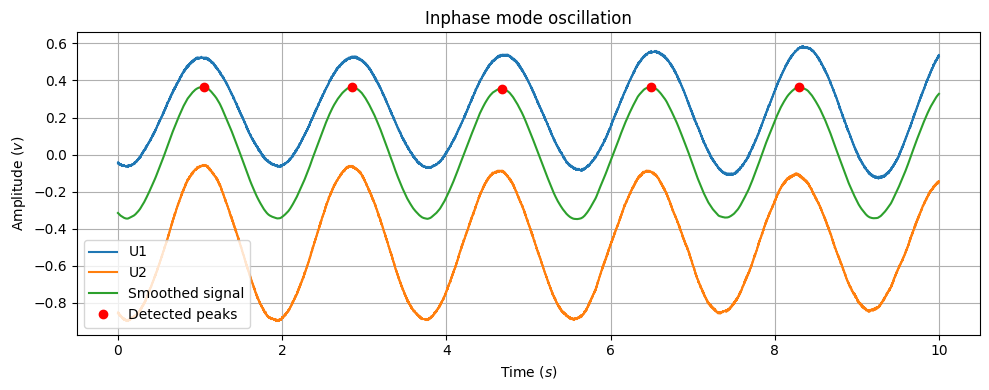

In [5]:
inphase_analyzer_3 = (
    CoupledPendulumAnalyzer('./data/inph3', mode='inphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks()
    .compute_period()
)

inphase_analyzer_3.report()
inphase_analyzer_3.plot()


C:\Users\Fatemeh Karimi\AppData\Local\Temp\ipykernel_26344\1580652488.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(self.path, delim_whitespace=True, decimal=',')


<IPython.core.display.Latex object>

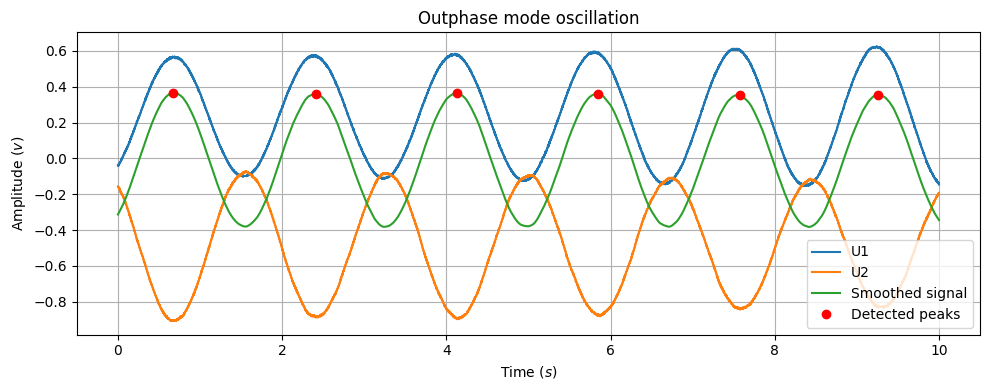

In [6]:
outphase_analyzer_3 = (
    CoupledPendulumAnalyzer('./data/outph3', mode='outphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_period()
)

outphase_analyzer_3.report()
outphase_analyzer_3.plot()

C:\Users\Fatemeh Karimi\AppData\Local\Temp\ipykernel_26344\1580652488.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(self.path, delim_whitespace=True, decimal=',')


[Beat mode] Envelope weak — T_s estimated from autocorrelation.


<IPython.core.display.Latex object>

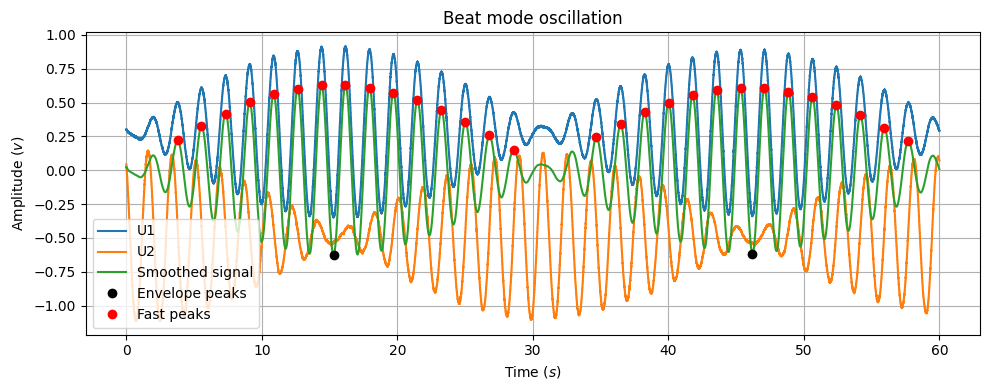

In [7]:
beat_analyzer_3 = (
    CoupledPendulumAnalyzer('./data/beat3', mode='beat')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_beat_periods()
)

beat_analyzer_3.report()
beat_analyzer_3.plot()


In [8]:
# Task 2: theoretical beat periods
T1, uT1 = inphase_analyzer_3.T_stats['median'], inphase_analyzer_3.T_stats['u_T']
T2, uT2 = outphase_analyzer_3.T_stats['median'], outphase_analyzer_3.T_stats['u_T']
beat_theory = compute_theoretical_beat(T1, uT1, T2, uT2)

# Task 3: coupling coefficient
coupling = compute_degree_of_coupling(T1, uT1, T2, uT2)

display(Latex(
f"$T'_{{theory}} = ({beat_theory['T_theory']:.3f} \\pm {beat_theory['u_T_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$T'_S = ({beat_theory['TS_theory']:.3f} \\pm {beat_theory['u_TS_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$k = ({coupling['k']:.4f} \\pm {coupling['u_k']:.4f})$"
))


<IPython.core.display.Latex object>

### For position 4

C:\Users\Fatemeh Karimi\AppData\Local\Temp\ipykernel_26344\1580652488.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(self.path, delim_whitespace=True, decimal=',')


<IPython.core.display.Latex object>

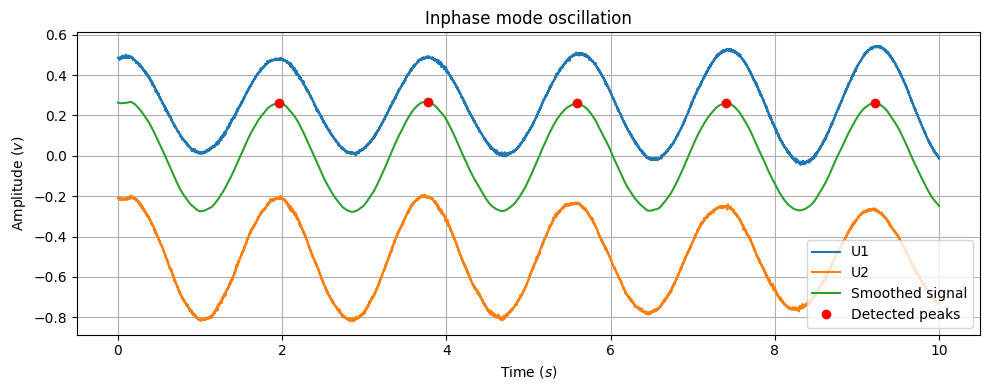

In [9]:
inphase_analyzer_4 = (
    CoupledPendulumAnalyzer('./data/inph4', mode='inphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_period()
)

inphase_analyzer_4.report()
inphase_analyzer_4.plot()

C:\Users\Fatemeh Karimi\AppData\Local\Temp\ipykernel_26344\1580652488.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(self.path, delim_whitespace=True, decimal=',')


<IPython.core.display.Latex object>

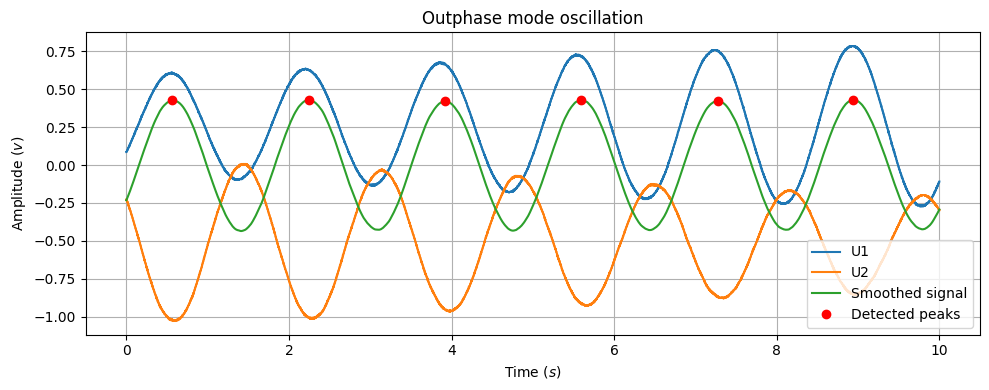

In [10]:
outphase_analyzer_4 = (
    CoupledPendulumAnalyzer('./data/outph4', mode='outphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_period()
)

outphase_analyzer_4.report()
outphase_analyzer_4.plot()

C:\Users\Fatemeh Karimi\AppData\Local\Temp\ipykernel_26344\1580652488.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(self.path, delim_whitespace=True, decimal=',')


[Beat mode] Envelope weak — T_s estimated from autocorrelation.


<IPython.core.display.Latex object>

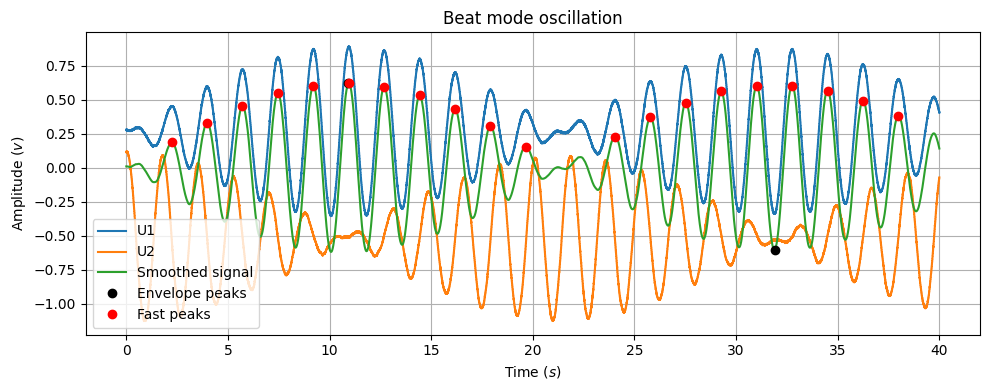

In [11]:
beat_analyzer_4 = (
    CoupledPendulumAnalyzer('./data/beat4', mode='beat')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_beat_periods()
)

beat_analyzer_4.report()
beat_analyzer_4.plot()

In [12]:
# Task 2: theoretical beat periods
T1, uT1 = inphase_analyzer_4.T_stats['median'], inphase_analyzer_4.T_stats['u_T']
T2, uT2 = outphase_analyzer_4.T_stats['median'], outphase_analyzer_4.T_stats['u_T']
beat_theory = compute_theoretical_beat(T1, uT1, T2, uT2)

# Task 3: coupling coefficient
coupling = compute_degree_of_coupling(T1, uT1, T2, uT2)

display(Latex(
f"$T'_{{theory}} = ({beat_theory['T_theory']:.3f} \\pm {beat_theory['u_T_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$T'_S = ({beat_theory['TS_theory']:.3f} \\pm {beat_theory['u_TS_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$k = ({coupling['k']:.4f} \\pm {coupling['u_k']:.4f})$"
))

<IPython.core.display.Latex object>

### For position 5

C:\Users\Fatemeh Karimi\AppData\Local\Temp\ipykernel_26344\1580652488.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(self.path, delim_whitespace=True, decimal=',')


<IPython.core.display.Latex object>

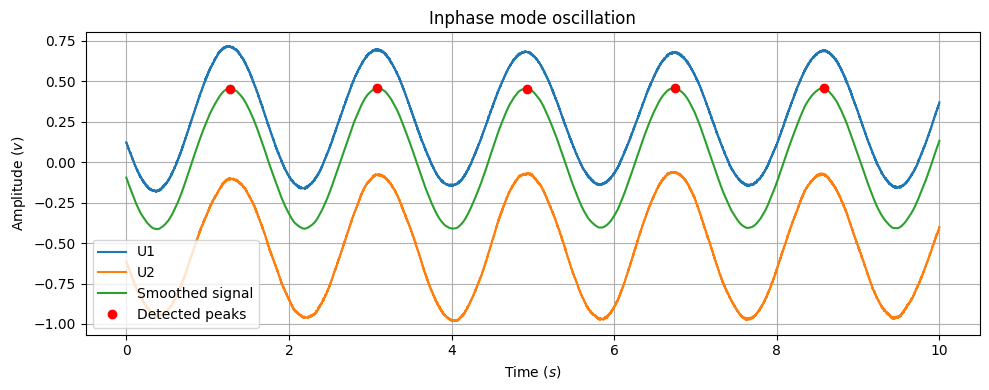

In [13]:
inphase_analyzer_5 = (
    CoupledPendulumAnalyzer('./data/inph5', mode='inphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_period()
)

inphase_analyzer_5.report()
inphase_analyzer_5.plot()

C:\Users\Fatemeh Karimi\AppData\Local\Temp\ipykernel_26344\1580652488.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(self.path, delim_whitespace=True, decimal=',')


<IPython.core.display.Latex object>

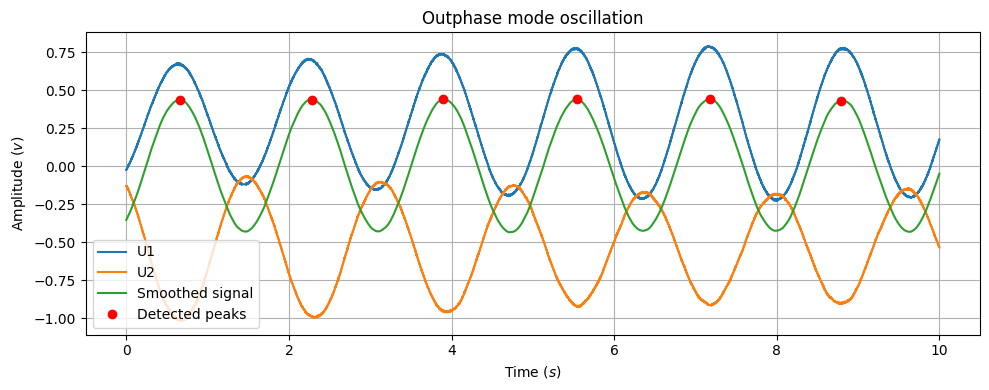

In [14]:
outphase_analyzer_5 = (
    CoupledPendulumAnalyzer('./data/outph5', mode='outphase')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_period()
)

outphase_analyzer_5.report()
outphase_analyzer_5.plot()

C:\Users\Fatemeh Karimi\AppData\Local\Temp\ipykernel_26344\1580652488.py:29: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(self.path, delim_whitespace=True, decimal=',')


[Beat mode] Envelope weak — T_s estimated from autocorrelation.


<IPython.core.display.Latex object>

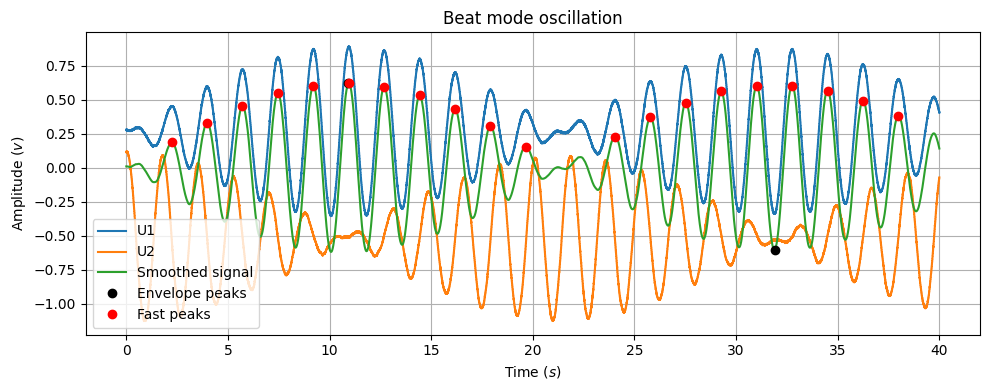

In [15]:
beat_analyzer_5 = (
    CoupledPendulumAnalyzer('./data/beat4', mode='beat')
    .load_data()
    .combine_signals()
    .preprocess()
    .detect_peaks(min_time=0.2, prom_frac=0.2)
    .compute_beat_periods()
)

beat_analyzer_5.report()
beat_analyzer_5.plot()

In [16]:
# Task 2: theoretical beat periods
T1, uT1 = inphase_analyzer_5.T_stats['median'], inphase_analyzer_5.T_stats['u_T']
T2, uT2 = outphase_analyzer_5.T_stats['median'], outphase_analyzer_5.T_stats['u_T']
beat_theory = compute_theoretical_beat(T1, uT1, T2, uT2)

# Task 3: coupling coefficient
coupling = compute_degree_of_coupling(T1, uT1, T2, uT2)

display(Latex(
f"$T'_{{theory}} = ({beat_theory['T_theory']:.3f} \\pm {beat_theory['u_T_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$T'_S = ({beat_theory['TS_theory']:.3f} \\pm {beat_theory['u_TS_theory']:.3f})~\\text{{s}}$ \\\n" +
f"$k = ({coupling['k']:.4f} \\pm {coupling['u_k']:.4f})$"
))

<IPython.core.display.Latex object>

In [17]:
# Spring constant from hanging-mass calibration (Hooke’s law)
def spring_constant_from_masses(m_g, h_cm, g=9.81):
    """
    Compute spring constant c from hanging-mass experiment.

    Parameters
    ----------
    m_g : list or array
        Masses in grams
    h_cm : list or array
        Measured spring lengths in cm
    g : float
        Gravitational acceleration (m/s^2)

    Returns
    -------
    dict with c [N/m] and u_c [N/m]
    """
    m = np.array(m_g) / 1000     # kg
    h = np.array(h_cm) / 100     # m

    L0 = np.max(h)               # assume smallest load = rest length
    dx = L0 - h
    F = m * g

    slope, intercept, r, p, stderr = linregress(dx, F)
    c, u_c = slope, stderr

    display(Latex(
    f"Hooke's-law calibration:  $F = c\\,\\Delta x$ \\\n" +
    f"$c = ({c:.2f} \\pm {u_c:.2f})\\,\\text{{N/m}}$ \\\n" +
    f"$R^2 = {r**2:.4f}$"
    ))
    return {"c": c, "u_c": u_c, "R2": r**2}

# Spring constant from coupled-pendulum periods (Task 4)
def spring_constant_from_periods(lF, T1, T2, m=1.3295, sA=0.747, g=9.81):
    """
    Determine c from slope of T1^2/T2^2 = 1 + (2c/D) * lF^2
    for Pendulum VII & VIII.

    lF : array-like [m]
    T1 : in-phase periods [s]
    T2 : out-of-phase periods [s]
    """
    D = m * g * sA                   # torque constant
    x = np.array(lF)**2
    y = (np.array(T1)**2) / (np.array(T2)**2)

    slope, intercept, r, p, stderr = linregress(x, y)
    c = slope * D / 2
    u_c = stderr * D / 2

    display(Latex(
        f"Linear relation:  $\\dfrac{{T_1^2}}{{T_2^2}} = 1 + \\dfrac{{2c}}{{D}}\\,l_F^2$ \\\n" +
        f"$D = m g s_A = {D:.3f} N m$ \\\n" +
        f"$\\Rightarrow\\; c = ({c:.3f} \\pm {u_c:.3f})N/m$ \\\n" +
        f"$R^2 = {r**2:.4f}$"
    ))

    return {"c": c, "u_c": u_c, "R2": r**2}


In [18]:
# Hanging-mass calibration ---
masses = [10,20,30,40,50,60,70]    # g
heights = [66.5,60,58,54.5,50.5,46.8,42.9]  # cm
spring_constant_from_masses(masses, heights)

<IPython.core.display.Latex object>

{'c': np.float64(2.596364601539817),
 'u_c': np.float64(0.11869475881479877),
 'R2': np.float64(0.9896584162706383)}

In [19]:
# Coupled pendulums (Task 4) ---
lF = [0.482, 0.582, 0.682]  # m
T1 = [inphase_analyzer_3.T_stats['median'], inphase_analyzer_4.T_stats['median'], inphase_analyzer_5.T_stats['median']]
T2 = [outphase_analyzer_3.T_stats['median'], outphase_analyzer_4.T_stats['median'], outphase_analyzer_5.T_stats['median']]
spring_constant_from_periods(lF, T1, T2)

<IPython.core.display.Latex object>

{'c': np.float64(3.0338453982770286),
 'u_c': np.float64(0.12316285092766611),
 'R2': np.float64(0.9983546533118135)}